In [1]:
import ModelingToolkit as Model
import SymPy as sp
import Symbolics as Symb
using DomainSets
import ApproxFun as AF
using NonlinearSolve
import DifferentialEquations as DE
include("multiharmonic_balance.jl");

In [8]:
gamma = 4;
omega = 5.0;
gamma3 = 6.0;
g0::Float64 = 9.80665; # m / s^2
height = 5.0; # m

In [15]:
xleft::Float64 = 0.0;
xright::Float64 = 1.0;
yleft = 0.0;
yright = 1.0;
Nt = 5
Nx = Ny = 40;
harmonics = 3; # number of harmonics
order = 2;
stepx = (xright-xleft)/Nx;
stepy = (yright - yleft)/Ny;
u0 = 0.005 * zeros((Nx+1) * (Ny+1) * harmonics * 2);
N = (Nx+1) * (Ny+1);

In [16]:
# Define symbolics
Model.@parameters x, y, t;

const Dy = Model.Differential(y)
const Dx = Model.Differential(x);
const Dt = Model.Differential(t);

In [17]:
function build_problem(x, y, t, omega, harmonics, xleft, xright, yleft, yright, gamma, gamma3)
    vars, var_exprs, (u,) = create_ansatz((x, y), t, omega, harmonics);
    F = 50 * exp(-40*(x^2)) * sin(omega*t);
    pde::Symbolics.Num = Dt(Dt(u)) - 9*(Dx(Dx(u)) + Dy(Dy(u))) + gamma*Dt(u) + gamma3*Dt(u)*Dt(u)*Dt(u) - F;
    return pde, var_exprs, vars;
end

function simplify_problem(pde, t, omega, harmonics, Nx, Ny, vars)
    expanded = expand_trig_jl(pde, t, omega)
    eqns = make_residual(expanded, harmonics, omega, t)
    sym_eqs = map(transform_sym(Nx, Ny) ∘ Meta.parse ∘ string, eqns)
    resid = create_residual_function(sym_eqs, vars, Nx, Ny)
    return resid
end

function solve_problem(resid, harmonics, Nx, Ny, u0, stepx, stepy)
    residual! = eval(resid)
    N = (Nx+1) * (Ny+1)
    
    R = similar(u0)

    # Simplify the jacobian to detect sparsity
    jac_sparsity = Symbolics.jacobian_sparsity(
        (R, U) -> Base.invokelatest(residual!, R, U, [stepx, stepy]), 
        R, u0
    )
    wrapped_residual! = (R, U, p) -> Base.invokelatest(residual!, R, U, p)
    
    f = NonlinearFunction(wrapped_residual!; jac_prototype=float.(jac_sparsity))
    prob = NonlinearProblem(f, u0, [stepx, stepy])
    sol = solve(prob, NewtonRaphson(), reltol=1e-5, abstol=1e-5, maxiters=2000)
    
    println(sol.retcode)
    solutions = [reshape(sol.u[(k-1)*N+1:k*N], Nx+1, Ny+1) for k in 1:(2*harmonics)]
    return solutions, sol
end

solve_problem (generic function with 1 method)

In [18]:
compute_time = @elapsed begin
    pde, var_exprs, vars = build_problem(x, y, t, omega, harmonics, xleft, xright, yleft, yright, gamma, gamma3)
    resid = simplify_problem(pde, t, omega, harmonics, Nx, Ny, vars)
    solutions, sol = solve_problem(resid, harmonics, Nx, Ny, u0, stepx, stepy)
end;
println("Compute time: $compute_time seconds")

Success
Compute time: 4.197330656 seconds


[ Info: Saved animation to /home/federico/projects/cse-minor/minor-project/TW3715TU-2025-ShallowWaters/harmonicBalance/harmonicBalancePlots/WaveEq_gino_3H.gif


Plots.AnimatedGif("/home/federico/projects/cse-minor/minor-project/TW3715TU-2025-ShallowWaters/harmonicBalance/harmonicBalancePlots/WaveEq_gino_3H.gif")
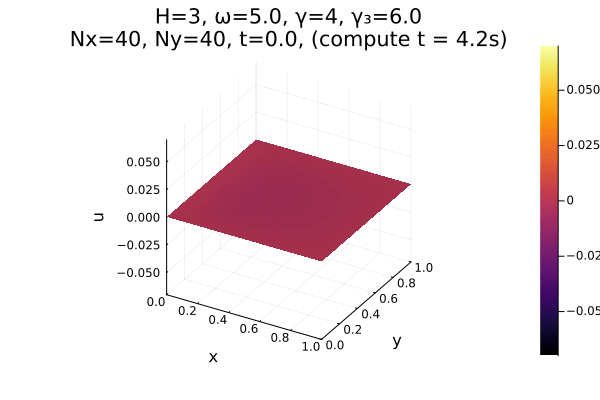

In [19]:
using Plots

x = range(0, 1, length=Nx+1)
y = range(0, 1, length=Ny+1)

T = 2π / omega
n_frames = 500
anim = @animate for t in range(0, T, length=n_frames)
    u_new = solutions[1] * 0.0
    j = 1
    for i in 1:(2*harmonics)
        if isodd(i)
            u_new .+= solutions[i] .* sin(j * omega * t)
        else
            u_new .+= solutions[i] .* cos(j * omega * t)
            j += 1
        end
    end
    
    surface(x, y, u_new', 
        zlims=(-0.07, 0.07), 
        clims=(-0.07, 0.07),
        xlabel="x", ylabel="y", zlabel="u",
    title = "H=$harmonics, ω=$(round(omega, digits=1)), " *
            "γ=$gamma, γ₃=$(round(gamma3, sigdigits=2))\n" *
            "Nx=$Nx, Ny=$Ny, t=$(round(t, digits=2)), (compute t = $(round(compute_time, digits=1))s)",
        camera=(30, 30)  # viewing angle
    )
end
gif(anim, "harmonicBalancePlots/WaveEq_gino_$(harmonics)H.gif", fps=60)

## Profiling the code

Please use the section below to analyse the performance of each function, this was already checked before creating the three main functions.

In [ ]:
@time begin
    expanded = expand_trig_jl(pde, t, omega);
end;

In [ ]:
@time begin
eqns = make_residual(expanded, harmonics, omega, t);
end;

In [ ]:
@time begin
sym_eqs = map(transform_sym(Nx, Ny) ∘ Meta.parse ∘ string, eqns)
end;

In [ ]:
@time begin
resid = create_residual_function(Nx, Ny, sym_eqs, vars)
end;

In [ ]:
residual! = eval(resid);
R = similar(u0);
jac_sparsity = Symbolics.jacobian_sparsity(
    (R, U) -> residual!(R, U, [stepx, stepy]), 
    R, u0
);

In [ ]:
# Create problem with sparsity
f = NonlinearFunction(residual!; jac_prototype=float.(jac_sparsity));
prob = NonlinearProblem(f, u0, [stepx, stepy]);

# Solve with sparse Jacobian
sol = solve(prob, NewtonRaphson(), reltol=1e-5, abstol=1e-5);
sol.retcode

In [ ]:
solutions = [reshape(sol.u[(k-1)*N+1:k*N], Nx+1, Ny+1) for k in 1:(2*harmonics)];